Xem giúp t các mô hình ML này cái :)))
* cách chia train-test có ghi ở bên dưới r (có thể điều chỉnh tuỳ ý nhá)
* mới có mẫu cho chunks thôi, tương tự cho full audio
* chạy giúp t các mô hình RF, Catboost, SVM, LightGBM, (xem các model trong một số paper để cài đặt lại nha).
* dùng các feature trong
** Senior Thesis/Workspace/recognition/ml_model/chunks
** Senior Thesis/Workspace/recognition/ml_model/full_audio

# Full Audio

# Chunks

## Features

* Need to split train - val - test (8:1:1)
* No chunks from one target are split to different sets.
* Label distribution must be 8:1:1
* Note: label 0: healthy, label 1: covid-19

### Set up

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import sys

import lightgbm as lgb
from sklearn import svm

from IPython.display import clear_output, Audio
import IPython.display as ipd
import os
import numpy as np
import shutil
import pandas as pd
import logging
import warnings

logger = logging.getLogger('ML MODEL')
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)
pd.set_option('display.max_colwidth', None)

warnings.filterwarnings("ignore")

clear_output()

In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/Senior Thesis/Workspace/recognition/ml_model/chunks'

# mel_aicovidvn = os.path.join(root, 'melspectrogram_aicovidvn_features.csv')
# mel_coswara = os.path.join(root, 'melspectrogram_coswara_features.csv')
# mel_coughvid = os.path.join(root, 'melspectrogram_coughvid_features.csv')

mfcc_13_coswara = os.path.join(root, 'mfcc_13_coswara_features.csv')
mfcc_26_coswara = os.path.join(root, 'mfcc_26_coswara_features.csv')
mfcc_39_coswara = os.path.join(root, 'mfcc_39_coswara_features.csv')

mfcc_13_coughvid = os.path.join(root, 'mfcc_13_coughvid_features.csv')
mfcc_26_coughvid = os.path.join(root, 'mfcc_26_coughvid_features.csv')
mfcc_39_coughvid = os.path.join(root, 'mfcc_39_coughvid_features.csv')

### AICovidVN

In [ ]:
def data_split(label0, label1):
  train = pd.concat([label0[:20818], label1[:4414]], ignore_index=True)
  val = pd.concat([label0[20818:23422], label1[4414:4961]], ignore_index=True)
  test = pd.concat([label0[23422:], label1[4961:]], ignore_index=True)

  train = train.sample(frac=1).reset_index(drop=True).drop(['uuid'], axis=1)
  val = val.sample(frac=1).reset_index(drop=True).drop(['uuid'], axis=1)
  test = test.sample(frac=1).reset_index(drop=True).drop(['uuid'], axis=1)

  return train, val, test

#### Melspectrogram

In [ ]:
metadata = '/content/drive/MyDrive/Colab Notebooks/Senior Thesis/Workspace/data preprocessing/cough_chunking/AICovidVN/aicovidvn_chunk_metadata.csv'
meta_df = pd.read_csv(metadata)
meta_df = meta_df[['uuid', 'label']]
meta_df

In [ ]:
mel_aicovidvn_df = pd.read_csv(mel_aicovidvn)
label0 = mel_aicovidvn_df[mel_aicovidvn_df['label']==0].copy().reset_index(drop=True)
label1 = mel_aicovidvn_df[mel_aicovidvn_df['label']==1].copy().reset_index(drop=True)

In [ ]:
# mel_aicovidvn_df.to_csv(mel_aicovidvn, index=0)

In [ ]:
train, val, test = data_split(label0, label1)

In [ ]:
train.shape,val.shape, test.shape

In [ ]:
X_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].values
X_val = val.iloc[:, :-1].values
y_val = val.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

### Coswara

In [ ]:
def data_split(label0, label1):
  train = pd.concat([label0[:13504], label1[:4803]], ignore_index=True)
  val = pd.concat([label0[13504:15186], label1[4803:5408]], ignore_index=True)
  test = pd.concat([label0[15186:], label1[5408:]], ignore_index=True)

  train = train.sample(frac=1).reset_index(drop=True)
  val = val.sample(frac=1).reset_index(drop=True)
  test = test.sample(frac=1).reset_index(drop=True)

  return train, val, test

#### Melspectrogram

In [ ]:
metadata = '/content/drive/MyDrive/Colab Notebooks/Senior Thesis/Workspace/data preprocessing/cough_chunking/coswara/coswara_chunk_metadata.csv'
meta_df = pd.read_csv(metadata)
meta_df = meta_df[['uuid', 'label']]
meta_df

,uuid,label
0,20200424-iV3Db6t1T8b7c5HQY2TwxIhjbzD3-cough-shallow-0,healthy
1,20200424-iV3Db6t1T8b7c5HQY2TwxIhjbzD3-cough-shallow-1,healthy
2,20200424-iV3Db6t1T8b7c5HQY2TwxIhjbzD3-cough-shallow-2,healthy
3,20200424-iV3Db6t1T8b7c5HQY2TwxIhjbzD3-cough-shallow-3,healthy
4,20200424-iV3Db6t1T8b7c5HQY2TwxIhjbzD3-cough-shallow-4,healthy
...,...,...
22873,20210714-iYwmYc9CdlSuzqGwIlXNWI6eFpm1-cough-heavy-4,positive_mild
22874,20210714-iYwmYc9CdlSuzqGwIlXNWI6eFpm1-cough-heavy-5,positive_mild
22875,20210714-iYwmYc9CdlSuzqGwIlXNWI6eFpm1-cough-heavy-6,positive_mild
22876,20210714-iYwmYc9CdlSuzqGwIlXNWI6eFpm1-cough-heavy-7,positive_mild


In [ ]:
meta_df.label.value_counts()

healthy                        14348
positive_mild                   2472
no_resp_illness_exposed         1861
resp_illness_not_identified     1595
positive_moderate               1091
recovered_full                   928
positive_asymp                   583
Name: label, dtype: int64

In [ ]:
meta_df.label = meta_df.label.map({
    'healthy': 0,
    'positive_mild': 1,
    'no_resp_illness_exposed': 1,
    'resp_illness_not_identified': 0,
    'positive_moderate': 1,
    'recovered_full': 0,
    'positive_asymp': 1
})

In [ ]:
meta_df.label.value_counts()

0    16871
1     6007
Name: label, dtype: int64

In [ ]:
mel_coswara_df = pd.read_csv(mel_coswara)
mel_coswara_df.label = mel_coswara_df.label.map({
    'healthy': 0,
    'positive_mild': 1,
    'no_resp_illness_exposed': 1,
    'resp_illness_not_identified': 0,
    'positive_moderate': 1,
    'recovered_full': 0,
    'positive_asymp': 1
})
label0 = mel_coswara_df[mel_coswara_df['label']==0].copy().reset_index(drop=True)
label1 = mel_coswara_df[mel_coswara_df['label']==1].copy().reset_index(drop=True)

In [ ]:
len(label0), len(label1)

(16871, 6007)

In [ ]:
train, val, test = data_split(label0, label1)

In [ ]:
train.shape, val.shape, test.shape

((18307, 225), (2287, 225), (2284, 225))

In [ ]:
train.label.value_counts(), val.label.value_counts(), test.label.value_counts(),

(0    13504
 1     4803
 Name: label, dtype: int64, 0    1682
 1     605
 Name: label, dtype: int64, 0    1685
 1     599
 Name: label, dtype: int64)

In [ ]:
X_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].values
X_val = val.iloc[:, :-1].values
y_val = val.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

#### MFCC

##### 13

In [ ]:
mfcc_coswara_df = pd.read_csv(mfcc_13_coswara)
mfcc_coswara_df.label = mfcc_coswara_df.label.map({
    'healthy': 0,
    'positive_mild': 1,
    'no_resp_illness_exposed': 1,
    'resp_illness_not_identified': 0,
    'positive_moderate': 1,
    'recovered_full': 0,
    'positive_asymp': 1
})
label0 = mfcc_coswara_df[mfcc_coswara_df['label']==0].copy().reset_index(drop=True)
label1 = mfcc_coswara_df[mfcc_coswara_df['label']==1].copy().reset_index(drop=True)

In [ ]:
len(label0), len(label1)

(16871, 6007)

In [ ]:
train, val, test = data_split(label0, label1)

In [ ]:
train.shape, val.shape, test.shape

((18307, 14), (2287, 14), (2284, 14))

In [ ]:
train.label.value_counts(), val.label.value_counts(), test.label.value_counts(),

(0    13504
 1     4803
 Name: label, dtype: int64, 0    1682
 1     605
 Name: label, dtype: int64, 0    1685
 1     599
 Name: label, dtype: int64)

In [ ]:
X_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].values
X_val = val.iloc[:, :-1].values
y_val = val.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

##### 26

In [ ]:
mfcc_coswara_df = pd.read_csv(mfcc_26_coswara)
mfcc_coswara_df.label = mfcc_coswara_df.label.map({
    'healthy': 0,
    'positive_mild': 1,
    'no_resp_illness_exposed': 1,
    'resp_illness_not_identified': 0,
    'positive_moderate': 1,
    'recovered_full': 0,
    'positive_asymp': 1
})
label0 = mfcc_coswara_df[mfcc_coswara_df['label']==0].copy().reset_index(drop=True)
label1 = mfcc_coswara_df[mfcc_coswara_df['label']==1].copy().reset_index(drop=True)

In [ ]:
len(label0), len(label1)

(16871, 6007)

In [ ]:
train, val, test = data_split(label0, label1)

In [ ]:
train.shape, val.shape, test.shape

((18307, 27), (2287, 27), (2284, 27))

In [ ]:
train.label.value_counts(), val.label.value_counts(), test.label.value_counts(),

(0    13504
 1     4803
 Name: label, dtype: int64, 0    1682
 1     605
 Name: label, dtype: int64, 0    1685
 1     599
 Name: label, dtype: int64)

In [ ]:
X_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].values
X_val = val.iloc[:, :-1].values
y_val = val.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

In [ ]:
train

### Coughvid

In [ ]:
def data_split(label0, label1):
  train = pd.concat([label0[:31893], label1[:10517]], ignore_index=True)
  val = pd.concat([label0[31893:35879], label1[10517:11824]], ignore_index=True)
  test = pd.concat([label0[35879:], label1[11824:]], ignore_index=True)

  train = train.sample(frac=1).reset_index(drop=True)
  val = val.sample(frac=1).reset_index(drop=True)
  test = test.sample(frac=1).reset_index(drop=True)

  return train, val, test

#### Melspectrogram

In [ ]:
metadata = '/content/drive/MyDrive/Colab Notebooks/Senior Thesis/Workspace/data preprocessing/cough_chunking/coughvid/coughvid_chunk_metadata.csv'
meta_df = pd.read_csv(metadata)
meta_df = meta_df[['uuid', 'label']]
meta_df

,uuid,label
0,00039425-7f3a-42aa-ac13-834aaa2b6b92-0,healthy
1,00039425-7f3a-42aa-ac13-834aaa2b6b92-1,healthy
2,00039425-7f3a-42aa-ac13-834aaa2b6b92-2,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a-0,healthy
4,0009eb28-d8be-4dc1-92bb-907e53bc5c7a-1,healthy
...,...,...
84976,fffaa9f8-4db0-46c5-90fb-93b7b014b55d-10,healthy
84977,fffaa9f8-4db0-46c5-90fb-93b7b014b55d-11,healthy
84978,fffaa9f8-4db0-46c5-90fb-93b7b014b55d-12,healthy
84979,fffaa9f8-4db0-46c5-90fb-93b7b014b55d-13,healthy


In [ ]:
meta_df.label.value_counts()

healthy        39866
symptomatic     8114
covid-19        5015
Name: label, dtype: int64

In [ ]:
# take index of null label
null_idx = []
for i, lb in enumerate(meta_df['label'].fillna('sos').tolist()):
  if lb == 'sos':
    null_idx.append(i)

In [ ]:
len(null_idx), meta_df.label.isnull().sum()

(31986, 31986)

In [ ]:
print(39866 + 8114 + 5015)

52995


In [ ]:
meta_df.label = meta_df.label.map({
    'healthy': 0,
    'symptomatic': 1,
    'covid-19': 1
})
meta_df.dropna(inplace=True)
meta_df.reset_index(drop=True, inplace=True)

In [ ]:
meta_df.label.value_counts()

0.0    39866
1.0    13129
Name: label, dtype: int64

In [ ]:
mel_coughvid_df = pd.read_csv(mel_coughvid)
mel_coughvid_df.dropna(inplace=True)
mel_coughvid_df.reset_index(drop=True, inplace=True)
mel_coughvid_df.label = mel_coughvid_df.label.map({
    'healthy': 0,
    'symptomatic': 1,
    'covid-19': 1
})
label0 = mel_coughvid_df[mel_coughvid_df['label']==0].copy().reset_index(drop=True)
label1 = mel_coughvid_df[mel_coughvid_df['label']==1].copy().reset_index(drop=True)

In [ ]:
len(label0), len(label1)

(39866, 13129)

In [ ]:
train, val, test = data_split(label0, label1)

In [ ]:
train.shape, val.shape, test.shape

((42410, 225), (5293, 225), (5292, 225))

In [ ]:
train.label.value_counts(), val.label.value_counts(), test.label.value_counts(),

(0    31893
 1    10517
 Name: label, dtype: int64, 0    3986
 1    1307
 Name: label, dtype: int64, 0    3987
 1    1305
 Name: label, dtype: int64)

In [ ]:
X_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].values
X_val = val.iloc[:, :-1].values
y_val = val.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

## Model

### AICovidVN

#### LGBM

In [ ]:
NUM_BOOST_ROUND = 10000
# NUM_CLASS = 2

params = {'objective':'binary',
          'boosting_type': 'gbdt',
          'metric' : 'auc',
          'learning_rate':0.03,
          'subsample':0.68,
          'tree_learner': 'serial',
          'colsample_bytree':0.28,
          'early_stopping_rounds':100,
          'subsample_freq': 1,
          'reg_lambda':2,
          'reg_alpha': 1,
          'num_leaves': 1000,
          'random_state':1999,
          }

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

seed_final_test = np.zeros(X_test.shape[0])
seed_final_val = np.zeros(X_val.shape[0])

seeds = range(30)

NUM_BOOST_ROUND = 1000
EARLY_STOPPING_ROUND = 100

SEED = 1999
n_splits = 3


# feature_important = None

for seed in seeds:
    final_test = np.zeros(X_test.shape[0])
    final_val = np.zeros(X_val.shape[0])

    logger.info(f'----------- seed: {seed} -----------')
    kfolds = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for trn_ind, val_ind in kfolds.split(X=X_train, y=y_train):

        kf_x_train, kf_y_train = X_train[trn_ind], y_train[trn_ind]
        kf_x_valid, kf_y_valid = X_train[val_ind], y_train[val_ind]
        
        print(kf_x_train.shape, kf_y_train.shape)
        
        dtrain = lgb.Dataset(kf_x_train, kf_y_train)
        dvalid = lgb.Dataset(kf_x_valid, kf_y_valid)
        
        params['random_state'] = seed

        model = lgb.train(params, 
                          dtrain, 
                          num_boost_round=NUM_BOOST_ROUND,
                          early_stopping_rounds=EARLY_STOPPING_ROUND,
                          valid_sets=(dtrain, dvalid), 
                          valid_names=('train','valid'),
                          verbose_eval = 100)

        test_pred  = model.predict(X_test)
        valid_pred = model.predict(X_val)

        # take the probability of second label
        final_test += test_pred
        final_val += valid_pred

        print('='*80)

    final_test /= n_splits
    final_val /= n_splits
    seed_final_test += final_test
    seed_final_val += final_val
    
seed_final_test /= len(seeds)
seed_final_val /= len(seeds)

2022-02-20 05:16:52,039 - ML MODEL - INFO - ----------- seed: 0 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995088	valid's auc: 0.847777
[200]	train's auc: 0.999834	valid's auc: 0.861352
[300]	train's auc: 0.999978	valid's auc: 0.866972
[400]	train's auc: 0.999993	valid's auc: 0.869375
[500]	train's auc: 0.999998	valid's auc: 0.870769
[600]	train's auc: 0.999999	valid's auc: 0.871136
[700]	train's auc: 1	valid's auc: 0.872029
[800]	train's auc: 1	valid's auc: 0.872285
[900]	train's auc: 1	valid's auc: 0.872738
Early stopping, best iteration is:
[810]	train's auc: 1	valid's auc: 0.872397
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994512	valid's auc: 0.83347
[200]	train's auc: 0.999841	valid's auc: 0.847834
[300]	train's auc: 0.999994	valid's auc: 0.852674
[400]	train's auc: 0.999999	valid's auc: 0.855089
[500]	train's auc: 1	valid's auc: 0.856749
[600]	train's auc: 1	valid's auc: 0.857217
[700]	train's auc: 1	valid's auc: 0.85

2022-02-20 05:18:47,074 - ML MODEL - INFO - ----------- seed: 1 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994948	valid's auc: 0.844419
[200]	train's auc: 0.999838	valid's auc: 0.859486
[300]	train's auc: 0.999975	valid's auc: 0.864746
[400]	train's auc: 0.99999	valid's auc: 0.866361
[500]	train's auc: 0.999997	valid's auc: 0.867836
[600]	train's auc: 0.999999	valid's auc: 0.868209
[700]	train's auc: 1	valid's auc: 0.869027
[800]	train's auc: 1	valid's auc: 0.869296
[900]	train's auc: 1	valid's auc: 0.869515
[1000]	train's auc: 1	valid's auc: 0.870121
Did not meet early stopping. Best iteration is:
[919]	train's auc: 1	valid's auc: 0.869794
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994907	valid's auc: 0.831957
[200]	train's auc: 0.99988	valid's auc: 0.848265
[300]	train's auc: 0.999987	valid's auc: 0.853613
[400]	train's auc: 0.999997	valid's auc: 0.856574
[500]	train's auc: 0.999999	valid's auc: 0.857816
[600]	train's auc:

2022-02-20 05:20:38,988 - ML MODEL - INFO - ----------- seed: 2 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995019	valid's auc: 0.844498
[200]	train's auc: 0.999829	valid's auc: 0.859854
[300]	train's auc: 0.999968	valid's auc: 0.865197
[400]	train's auc: 0.999979	valid's auc: 0.86719
[500]	train's auc: 0.999998	valid's auc: 0.868729
[600]	train's auc: 1	valid's auc: 0.869668
[700]	train's auc: 1	valid's auc: 0.870493
[800]	train's auc: 1	valid's auc: 0.871108
[900]	train's auc: 1	valid's auc: 0.871613
[1000]	train's auc: 1	valid's auc: 0.87149
Did not meet early stopping. Best iteration is:
[942]	train's auc: 1	valid's auc: 0.87148
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994778	valid's auc: 0.827597
[200]	train's auc: 0.999879	valid's auc: 0.844159
[300]	train's auc: 0.999992	valid's auc: 0.850893
[400]	train's auc: 0.999998	valid's auc: 0.853863
[500]	train's auc: 1	valid's auc: 0.855184
[600]	train's auc: 1	valid's auc:

2022-02-20 05:23:01,030 - ML MODEL - INFO - ----------- seed: 3 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995386	valid's auc: 0.844167
[200]	train's auc: 0.99986	valid's auc: 0.85996
[300]	train's auc: 0.999982	valid's auc: 0.86544
[400]	train's auc: 0.999994	valid's auc: 0.868756
[500]	train's auc: 0.999998	valid's auc: 0.870113
[600]	train's auc: 1	valid's auc: 0.871184
[700]	train's auc: 1	valid's auc: 0.871412
[800]	train's auc: 1	valid's auc: 0.871652
Early stopping, best iteration is:
[743]	train's auc: 1	valid's auc: 0.87162
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995294	valid's auc: 0.832564
[200]	train's auc: 0.999858	valid's auc: 0.848023
[300]	train's auc: 0.999987	valid's auc: 0.854875
[400]	train's auc: 0.999997	valid's auc: 0.857923
[500]	train's auc: 1	valid's auc: 0.859577
[600]	train's auc: 1	valid's auc: 0.860284
[700]	train's auc: 1	valid's auc: 0.860921
Early stopping, best iteration is:
[641]	train's

2022-02-20 05:26:22,120 - ML MODEL - INFO - ----------- seed: 4 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995173	valid's auc: 0.843683
[200]	train's auc: 0.999819	valid's auc: 0.859374
[300]	train's auc: 0.999979	valid's auc: 0.865135
[400]	train's auc: 0.999992	valid's auc: 0.868146
[500]	train's auc: 0.999997	valid's auc: 0.869647
[600]	train's auc: 0.999999	valid's auc: 0.870778
[700]	train's auc: 1	valid's auc: 0.871267
[800]	train's auc: 1	valid's auc: 0.871634
[900]	train's auc: 1	valid's auc: 0.872028
[1000]	train's auc: 1	valid's auc: 0.87248
Did not meet early stopping. Best iteration is:
[938]	train's auc: 1	valid's auc: 0.872328
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995105	valid's auc: 0.830154
[200]	train's auc: 0.999867	valid's auc: 0.84655
[300]	train's auc: 0.999987	valid's auc: 0.85309
[400]	train's auc: 0.999998	valid's auc: 0.856255
[500]	train's auc: 1	valid's auc: 0.858287
[600]	train's auc: 1	valid

2022-02-20 05:28:07,654 - ML MODEL - INFO - ----------- seed: 5 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994629	valid's auc: 0.842932
[200]	train's auc: 0.999801	valid's auc: 0.85794
[300]	train's auc: 0.999942	valid's auc: 0.864235
[400]	train's auc: 0.999947	valid's auc: 0.86661
Early stopping, best iteration is:
[382]	train's auc: 0.999951	valid's auc: 0.86622
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994334	valid's auc: 0.830915
[200]	train's auc: 0.999723	valid's auc: 0.848393
[300]	train's auc: 0.999891	valid's auc: 0.853933
[400]	train's auc: 0.999995	valid's auc: 0.857032
[500]	train's auc: 0.999999	valid's auc: 0.858171
[600]	train's auc: 1	valid's auc: 0.859306
[700]	train's auc: 1	valid's auc: 0.859499
[800]	train's auc: 1	valid's auc: 0.859722
Early stopping, best iteration is:
[748]	train's auc: 1	valid's auc: 0.85956
(16822, 224) (16822,)
Training until validation scores don't improve for 100 rounds.
[100]	t

2022-02-20 05:29:37,001 - ML MODEL - INFO - ----------- seed: 6 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995074	valid's auc: 0.846653
[200]	train's auc: 0.999847	valid's auc: 0.860554
[300]	train's auc: 0.999976	valid's auc: 0.865036
[400]	train's auc: 0.999992	valid's auc: 0.868179
[500]	train's auc: 0.999998	valid's auc: 0.869182
[600]	train's auc: 0.999999	valid's auc: 0.870177
[700]	train's auc: 1	valid's auc: 0.871666
[800]	train's auc: 1	valid's auc: 0.871712
Early stopping, best iteration is:
[727]	train's auc: 1	valid's auc: 0.871859
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994787	valid's auc: 0.832177
[200]	train's auc: 0.999834	valid's auc: 0.84817
[300]	train's auc: 0.999982	valid's auc: 0.854878
[400]	train's auc: 0.999997	valid's auc: 0.857275
[500]	train's auc: 1	valid's auc: 0.858226
[600]	train's auc: 1	valid's auc: 0.858451
[700]	train's auc: 1	valid's auc: 0.859417
Early stopping, best iteration is:
[61

2022-02-20 05:31:17,472 - ML MODEL - INFO - ----------- seed: 7 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995051	valid's auc: 0.844787
[200]	train's auc: 0.999862	valid's auc: 0.859607
[300]	train's auc: 0.999974	valid's auc: 0.864576
[400]	train's auc: 0.999992	valid's auc: 0.867367
[500]	train's auc: 0.999998	valid's auc: 0.868639
[600]	train's auc: 1	valid's auc: 0.869919
[700]	train's auc: 1	valid's auc: 0.870115
[800]	train's auc: 1	valid's auc: 0.870363
[900]	train's auc: 1	valid's auc: 0.870381
Early stopping, best iteration is:
[888]	train's auc: 1	valid's auc: 0.87035
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994545	valid's auc: 0.831454
[200]	train's auc: 0.999765	valid's auc: 0.847178
[300]	train's auc: 0.999976	valid's auc: 0.852983
[400]	train's auc: 0.999996	valid's auc: 0.855625
[500]	train's auc: 0.999999	valid's auc: 0.857143
[600]	train's auc: 1	valid's auc: 0.857742
[700]	train's auc: 1	valid's auc: 0.85

2022-02-20 05:33:03,407 - ML MODEL - INFO - ----------- seed: 8 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994914	valid's auc: 0.848318
[200]	train's auc: 0.99982	valid's auc: 0.861871
[300]	train's auc: 0.99995	valid's auc: 0.866207
[400]	train's auc: 0.999974	valid's auc: 0.868673
[500]	train's auc: 0.999981	valid's auc: 0.870238
[600]	train's auc: 0.999982	valid's auc: 0.870819
[700]	train's auc: 0.999986	valid's auc: 0.871496
[800]	train's auc: 0.999985	valid's auc: 0.871846
Early stopping, best iteration is:
[737]	train's auc: 0.999988	valid's auc: 0.871586
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.99484	valid's auc: 0.832369
[200]	train's auc: 0.999855	valid's auc: 0.848856
[300]	train's auc: 0.999985	valid's auc: 0.854875
[400]	train's auc: 0.999997	valid's auc: 0.857626
[500]	train's auc: 0.999999	valid's auc: 0.858835
[600]	train's auc: 1	valid's auc: 0.859279
[700]	train's auc: 1	valid's auc: 0.8599
[800]	train's 

2022-02-20 05:34:44,733 - ML MODEL - INFO - ----------- seed: 9 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994742	valid's auc: 0.843403
[200]	train's auc: 0.999857	valid's auc: 0.857814
[300]	train's auc: 0.999979	valid's auc: 0.863338
[400]	train's auc: 0.999991	valid's auc: 0.865281
[500]	train's auc: 0.999998	valid's auc: 0.866652
[600]	train's auc: 1	valid's auc: 0.867891
[700]	train's auc: 1	valid's auc: 0.868507
[800]	train's auc: 1	valid's auc: 0.868846
Early stopping, best iteration is:
[784]	train's auc: 1	valid's auc: 0.868699
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994812	valid's auc: 0.830974
[200]	train's auc: 0.999804	valid's auc: 0.846788
[300]	train's auc: 0.999969	valid's auc: 0.852262
[400]	train's auc: 0.99998	valid's auc: 0.855425
[500]	train's auc: 0.999985	valid's auc: 0.856966
[600]	train's auc: 1	valid's auc: 0.858108
[700]	train's auc: 1	valid's auc: 0.858937
Early stopping, best iteration is:
[69

2022-02-20 05:36:33,551 - ML MODEL - INFO - ----------- seed: 10 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994682	valid's auc: 0.846359
[200]	train's auc: 0.999836	valid's auc: 0.860633
[300]	train's auc: 0.999984	valid's auc: 0.866143
[400]	train's auc: 0.999993	valid's auc: 0.868475
[500]	train's auc: 0.999998	valid's auc: 0.870321
[600]	train's auc: 1	valid's auc: 0.871722
[700]	train's auc: 1	valid's auc: 0.872227
[800]	train's auc: 1	valid's auc: 0.872438
Early stopping, best iteration is:
[776]	train's auc: 1	valid's auc: 0.872515
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994792	valid's auc: 0.828064
[200]	train's auc: 0.999839	valid's auc: 0.844873
[300]	train's auc: 0.999989	valid's auc: 0.851369
[400]	train's auc: 0.999997	valid's auc: 0.85413
[500]	train's auc: 0.999999	valid's auc: 0.856416
[600]	train's auc: 1	valid's auc: 0.856716
[700]	train's auc: 1	valid's auc: 0.857538
[800]	train's auc: 1	valid's auc: 0.85

2022-02-20 05:38:17,304 - ML MODEL - INFO - ----------- seed: 11 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994737	valid's auc: 0.84578
[200]	train's auc: 0.999744	valid's auc: 0.858734
[300]	train's auc: 0.999927	valid's auc: 0.864176
[400]	train's auc: 0.999949	valid's auc: 0.866013
[500]	train's auc: 0.99995	valid's auc: 0.867619
Early stopping, best iteration is:
[451]	train's auc: 0.999953	valid's auc: 0.867003
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994895	valid's auc: 0.829841
[200]	train's auc: 0.99987	valid's auc: 0.845337
[300]	train's auc: 0.999977	valid's auc: 0.850517
[400]	train's auc: 0.999995	valid's auc: 0.853862
[500]	train's auc: 0.999999	valid's auc: 0.855395
[600]	train's auc: 1	valid's auc: 0.855827
[700]	train's auc: 1	valid's auc: 0.856716
Early stopping, best iteration is:
[685]	train's auc: 1	valid's auc: 0.856624
(16822, 224) (16822,)
Training until validation scores don't improve for 100 rounds.

2022-02-20 05:39:47,312 - ML MODEL - INFO - ----------- seed: 12 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.99488	valid's auc: 0.845369
[200]	train's auc: 0.999815	valid's auc: 0.859292
[300]	train's auc: 0.999982	valid's auc: 0.864732
[400]	train's auc: 0.999994	valid's auc: 0.866869
[500]	train's auc: 0.999998	valid's auc: 0.868063
[600]	train's auc: 1	valid's auc: 0.869139
[700]	train's auc: 1	valid's auc: 0.869849
[800]	train's auc: 1	valid's auc: 0.870157
Early stopping, best iteration is:
[748]	train's auc: 1	valid's auc: 0.870235
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994864	valid's auc: 0.835462
[200]	train's auc: 0.999866	valid's auc: 0.849679
[300]	train's auc: 0.999989	valid's auc: 0.855203
[400]	train's auc: 0.999997	valid's auc: 0.857916
[500]	train's auc: 0.999999	valid's auc: 0.858582
[600]	train's auc: 1	valid's auc: 0.859465
[700]	train's auc: 1	valid's auc: 0.860184
Early stopping, best iteration is:
[68

2022-02-20 05:41:29,980 - ML MODEL - INFO - ----------- seed: 13 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994814	valid's auc: 0.846431
[200]	train's auc: 0.999851	valid's auc: 0.859991
[300]	train's auc: 0.999985	valid's auc: 0.864357
[400]	train's auc: 0.999995	valid's auc: 0.866978
[500]	train's auc: 0.999999	valid's auc: 0.868521
[600]	train's auc: 1	valid's auc: 0.869089
[700]	train's auc: 1	valid's auc: 0.869479
[800]	train's auc: 1	valid's auc: 0.869831
Early stopping, best iteration is:
[740]	train's auc: 1	valid's auc: 0.869422
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994657	valid's auc: 0.830008
[200]	train's auc: 0.999834	valid's auc: 0.848052
[300]	train's auc: 0.999955	valid's auc: 0.853116
[400]	train's auc: 0.999985	valid's auc: 0.85647
[500]	train's auc: 1	valid's auc: 0.857616
[600]	train's auc: 1	valid's auc: 0.858176
[700]	train's auc: 1	valid's auc: 0.85811
Early stopping, best iteration is:
[625]	train

2022-02-20 05:43:10,564 - ML MODEL - INFO - ----------- seed: 14 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.99503	valid's auc: 0.848079
[200]	train's auc: 0.999781	valid's auc: 0.860639
[300]	train's auc: 0.999919	valid's auc: 0.865398
[400]	train's auc: 0.999935	valid's auc: 0.867773
Early stopping, best iteration is:
[397]	train's auc: 0.999935	valid's auc: 0.867658
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994197	valid's auc: 0.830712
[200]	train's auc: 0.999663	valid's auc: 0.845682
[300]	train's auc: 0.999992	valid's auc: 0.85144
[400]	train's auc: 0.999999	valid's auc: 0.85436
[500]	train's auc: 1	valid's auc: 0.855954
[600]	train's auc: 1	valid's auc: 0.856698
Early stopping, best iteration is:
[594]	train's auc: 1	valid's auc: 0.856807
(16822, 224) (16822,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.99503	valid's auc: 0.844036
[200]	train's auc: 0.999743	valid's auc: 0.856703


2022-02-20 05:44:36,812 - ML MODEL - INFO - ----------- seed: 15 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995044	valid's auc: 0.847579
[200]	train's auc: 0.999875	valid's auc: 0.860195
[300]	train's auc: 0.99998	valid's auc: 0.865512
[400]	train's auc: 0.999994	valid's auc: 0.868213
[500]	train's auc: 0.999998	valid's auc: 0.869775
[600]	train's auc: 1	valid's auc: 0.870644
[700]	train's auc: 1	valid's auc: 0.871502
[800]	train's auc: 1	valid's auc: 0.871399
Early stopping, best iteration is:
[701]	train's auc: 1	valid's auc: 0.871539
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994927	valid's auc: 0.832377
[200]	train's auc: 0.999886	valid's auc: 0.847657
[300]	train's auc: 0.999991	valid's auc: 0.853236
[400]	train's auc: 0.999998	valid's auc: 0.855522
[500]	train's auc: 1	valid's auc: 0.857836
[600]	train's auc: 1	valid's auc: 0.858962
[700]	train's auc: 1	valid's auc: 0.859256
Early stopping, best iteration is:
[691]	trai

2022-02-20 05:46:16,176 - ML MODEL - INFO - ----------- seed: 16 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995131	valid's auc: 0.848553
[200]	train's auc: 0.999869	valid's auc: 0.862192
[300]	train's auc: 0.999983	valid's auc: 0.868216
[400]	train's auc: 0.999992	valid's auc: 0.870343
[500]	train's auc: 0.999998	valid's auc: 0.871889
[600]	train's auc: 1	valid's auc: 0.872812
[700]	train's auc: 1	valid's auc: 0.872979
[800]	train's auc: 1	valid's auc: 0.87341
[900]	train's auc: 1	valid's auc: 0.873664
Early stopping, best iteration is:
[807]	train's auc: 1	valid's auc: 0.873411
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995134	valid's auc: 0.830613
[200]	train's auc: 0.999834	valid's auc: 0.846916
[300]	train's auc: 0.999989	valid's auc: 0.852703
[400]	train's auc: 0.999998	valid's auc: 0.8548
[500]	train's auc: 1	valid's auc: 0.855562
[600]	train's auc: 1	valid's auc: 0.856888
[700]	train's auc: 1	valid's auc: 0.857562
Earl

2022-02-20 05:47:59,375 - ML MODEL - INFO - ----------- seed: 17 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994579	valid's auc: 0.846264
[200]	train's auc: 0.999786	valid's auc: 0.85827
[300]	train's auc: 0.999895	valid's auc: 0.864037
[400]	train's auc: 0.999922	valid's auc: 0.867226
[500]	train's auc: 0.999926	valid's auc: 0.867916
[600]	train's auc: 0.999931	valid's auc: 0.868998
Early stopping, best iteration is:
[553]	train's auc: 0.999936	valid's auc: 0.868536
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994829	valid's auc: 0.831289
[200]	train's auc: 0.999823	valid's auc: 0.846881
[300]	train's auc: 0.999991	valid's auc: 0.852468
[400]	train's auc: 0.999999	valid's auc: 0.856078
[500]	train's auc: 1	valid's auc: 0.857599
[600]	train's auc: 1	valid's auc: 0.858138
[700]	train's auc: 1	valid's auc: 0.858523
Early stopping, best iteration is:
[606]	train's auc: 1	valid's auc: 0.858084
(16822, 224) (16822,)
Training until va

2022-02-20 05:49:31,968 - ML MODEL - INFO - ----------- seed: 18 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995209	valid's auc: 0.8474
[200]	train's auc: 0.999813	valid's auc: 0.860356
[300]	train's auc: 0.999984	valid's auc: 0.866259
[400]	train's auc: 0.999992	valid's auc: 0.86867
[500]	train's auc: 0.999997	valid's auc: 0.870127
[600]	train's auc: 1	valid's auc: 0.871245
[700]	train's auc: 1	valid's auc: 0.871646
[800]	train's auc: 1	valid's auc: 0.871895
[900]	train's auc: 1	valid's auc: 0.872192
Early stopping, best iteration is:
[871]	train's auc: 1	valid's auc: 0.87207
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995204	valid's auc: 0.834111
[200]	train's auc: 0.999859	valid's auc: 0.847181
[300]	train's auc: 0.999989	valid's auc: 0.853249
[400]	train's auc: 0.999998	valid's auc: 0.855312
[500]	train's auc: 1	valid's auc: 0.857624
[600]	train's auc: 1	valid's auc: 0.858695
[700]	train's auc: 1	valid's auc: 0.859463
Early

2022-02-20 05:51:15,427 - ML MODEL - INFO - ----------- seed: 19 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994918	valid's auc: 0.844481
[200]	train's auc: 0.999876	valid's auc: 0.858951
[300]	train's auc: 0.999985	valid's auc: 0.863314
[400]	train's auc: 0.999995	valid's auc: 0.865506
[500]	train's auc: 0.999999	valid's auc: 0.866546
[600]	train's auc: 1	valid's auc: 0.86769
[700]	train's auc: 1	valid's auc: 0.868189
[800]	train's auc: 1	valid's auc: 0.868709
Early stopping, best iteration is:
[703]	train's auc: 1	valid's auc: 0.868219
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994721	valid's auc: 0.82963
[200]	train's auc: 0.999866	valid's auc: 0.84686
[300]	train's auc: 0.999991	valid's auc: 0.853074
[400]	train's auc: 0.999998	valid's auc: 0.856179
[500]	train's auc: 1	valid's auc: 0.858507
[600]	train's auc: 1	valid's auc: 0.859048
[700]	train's auc: 1	valid's auc: 0.859415
Early stopping, best iteration is:
[698]	train'

2022-02-20 05:52:55,666 - ML MODEL - INFO - ----------- seed: 20 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994552	valid's auc: 0.847853
[200]	train's auc: 0.99978	valid's auc: 0.859972
[300]	train's auc: 0.999942	valid's auc: 0.865184
[400]	train's auc: 0.999954	valid's auc: 0.867502
[500]	train's auc: 0.999958	valid's auc: 0.868801
[600]	train's auc: 0.999963	valid's auc: 0.869558
[700]	train's auc: 0.999965	valid's auc: 0.870611
Early stopping, best iteration is:
[695]	train's auc: 0.999965	valid's auc: 0.870581
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994732	valid's auc: 0.825158
[200]	train's auc: 0.999852	valid's auc: 0.844303
[300]	train's auc: 0.999959	valid's auc: 0.85082
[400]	train's auc: 0.999973	valid's auc: 0.85384
Early stopping, best iteration is:
[395]	train's auc: 0.999975	valid's auc: 0.853695
(16822, 224) (16822,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995114	

2022-02-20 05:54:28,869 - ML MODEL - INFO - ----------- seed: 21 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995263	valid's auc: 0.843847
[200]	train's auc: 0.999838	valid's auc: 0.859233
[300]	train's auc: 0.999981	valid's auc: 0.863964
[400]	train's auc: 0.999994	valid's auc: 0.866584
[500]	train's auc: 0.999999	valid's auc: 0.868133
[600]	train's auc: 1	valid's auc: 0.869199
[700]	train's auc: 1	valid's auc: 0.869596
[800]	train's auc: 1	valid's auc: 0.870384
Early stopping, best iteration is:
[714]	train's auc: 1	valid's auc: 0.86958
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995364	valid's auc: 0.833193
[200]	train's auc: 0.999826	valid's auc: 0.849062
[300]	train's auc: 0.999978	valid's auc: 0.854126
[400]	train's auc: 0.999998	valid's auc: 0.857047
[500]	train's auc: 1	valid's auc: 0.858866
[600]	train's auc: 1	valid's auc: 0.859817
[700]	train's auc: 1	valid's auc: 0.860147
Early stopping, best iteration is:
[646]	trai

2022-02-20 05:56:02,999 - ML MODEL - INFO - ----------- seed: 22 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995336	valid's auc: 0.846582
[200]	train's auc: 0.999835	valid's auc: 0.860894
[300]	train's auc: 0.999979	valid's auc: 0.866128
[400]	train's auc: 0.999992	valid's auc: 0.868775
[500]	train's auc: 0.999998	valid's auc: 0.869705
[600]	train's auc: 0.999999	valid's auc: 0.871054
[700]	train's auc: 1	valid's auc: 0.872275
[800]	train's auc: 1	valid's auc: 0.872745
[900]	train's auc: 1	valid's auc: 0.873201
Early stopping, best iteration is:
[810]	train's auc: 1	valid's auc: 0.872737
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994837	valid's auc: 0.832036
[200]	train's auc: 0.999879	valid's auc: 0.848188
[300]	train's auc: 0.999993	valid's auc: 0.855183
[400]	train's auc: 0.999999	valid's auc: 0.857943
[500]	train's auc: 1	valid's auc: 0.859516
[600]	train's auc: 1	valid's auc: 0.860244
[700]	train's auc: 1	valid's auc: 0.8

2022-02-20 05:57:44,209 - ML MODEL - INFO - ----------- seed: 23 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995195	valid's auc: 0.84478
[200]	train's auc: 0.999742	valid's auc: 0.858429
[300]	train's auc: 0.99992	valid's auc: 0.864288
[400]	train's auc: 0.999935	valid's auc: 0.866533
[500]	train's auc: 0.999953	valid's auc: 0.869042
[600]	train's auc: 0.999962	valid's auc: 0.869824
[700]	train's auc: 0.999964	valid's auc: 0.870379
Early stopping, best iteration is:
[652]	train's auc: 0.999968	valid's auc: 0.870212
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.99522	valid's auc: 0.82931
[200]	train's auc: 0.99988	valid's auc: 0.845659
[300]	train's auc: 0.99999	valid's auc: 0.852372
[400]	train's auc: 0.999999	valid's auc: 0.856477
[500]	train's auc: 1	valid's auc: 0.85815
[600]	train's auc: 1	valid's auc: 0.858863
[700]	train's auc: 1	valid's auc: 0.859934
Early stopping, best iteration is:
[611]	train's auc: 1	valid's auc: 0.85

2022-02-20 05:59:21,519 - ML MODEL - INFO - ----------- seed: 24 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995453	valid's auc: 0.84499
[200]	train's auc: 0.999871	valid's auc: 0.857146
[300]	train's auc: 0.999981	valid's auc: 0.863
[400]	train's auc: 0.999996	valid's auc: 0.865621
[500]	train's auc: 0.999998	valid's auc: 0.86737
[600]	train's auc: 1	valid's auc: 0.868496
[700]	train's auc: 1	valid's auc: 0.868964
[800]	train's auc: 1	valid's auc: 0.869273
[900]	train's auc: 1	valid's auc: 0.869647
Early stopping, best iteration is:
[854]	train's auc: 1	valid's auc: 0.869341
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994941	valid's auc: 0.828169
[200]	train's auc: 0.999857	valid's auc: 0.847237
[300]	train's auc: 0.999988	valid's auc: 0.852828
[400]	train's auc: 0.999998	valid's auc: 0.855563
[500]	train's auc: 1	valid's auc: 0.857298
[600]	train's auc: 1	valid's auc: 0.858786
[700]	train's auc: 1	valid's auc: 0.859207
Early 

2022-02-20 06:01:07,135 - ML MODEL - INFO - ----------- seed: 25 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995449	valid's auc: 0.844195
[200]	train's auc: 0.999834	valid's auc: 0.859196
[300]	train's auc: 0.999962	valid's auc: 0.864406
[400]	train's auc: 0.999993	valid's auc: 0.867479
[500]	train's auc: 0.999998	valid's auc: 0.868926
[600]	train's auc: 1	valid's auc: 0.870012
[700]	train's auc: 1	valid's auc: 0.871074
[800]	train's auc: 1	valid's auc: 0.871444
Early stopping, best iteration is:
[765]	train's auc: 1	valid's auc: 0.871414
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.995375	valid's auc: 0.831469
[200]	train's auc: 0.999874	valid's auc: 0.850237
[300]	train's auc: 0.999985	valid's auc: 0.855517
[400]	train's auc: 0.999998	valid's auc: 0.857759
[500]	train's auc: 1	valid's auc: 0.858583
[600]	train's auc: 1	valid's auc: 0.85924
[700]	train's auc: 1	valid's auc: 0.860396
Early stopping, best iteration is:
[678]	trai

2022-02-20 06:02:49,293 - ML MODEL - INFO - ----------- seed: 26 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994468	valid's auc: 0.84499
[200]	train's auc: 0.999717	valid's auc: 0.8572
[300]	train's auc: 0.999912	valid's auc: 0.864457
[400]	train's auc: 0.999926	valid's auc: 0.866885
[500]	train's auc: 0.999945	valid's auc: 0.868774
[600]	train's auc: 0.999949	valid's auc: 0.869777
[700]	train's auc: 0.99994	valid's auc: 0.870426
Early stopping, best iteration is:
[604]	train's auc: 0.99995	valid's auc: 0.869875
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.99494	valid's auc: 0.831045
[200]	train's auc: 0.999837	valid's auc: 0.84688
[300]	train's auc: 0.999977	valid's auc: 0.853114
[400]	train's auc: 0.999997	valid's auc: 0.855825
[500]	train's auc: 1	valid's auc: 0.857185
[600]	train's auc: 1	valid's auc: 0.858817
[700]	train's auc: 1	valid's auc: 0.859528
Early stopping, best iteration is:
[627]	train's auc: 1	valid's auc: 0.85

2022-02-20 06:04:24,552 - ML MODEL - INFO - ----------- seed: 27 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994797	valid's auc: 0.844062
[200]	train's auc: 0.999839	valid's auc: 0.860518
[300]	train's auc: 0.999978	valid's auc: 0.865653
[400]	train's auc: 0.999994	valid's auc: 0.868556
[500]	train's auc: 0.999997	valid's auc: 0.86997
[600]	train's auc: 0.999999	valid's auc: 0.871102
[700]	train's auc: 1	valid's auc: 0.871534
[800]	train's auc: 1	valid's auc: 0.871593
[900]	train's auc: 1	valid's auc: 0.871875
Early stopping, best iteration is:
[890]	train's auc: 1	valid's auc: 0.871855
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994545	valid's auc: 0.830054
[200]	train's auc: 0.999729	valid's auc: 0.846005
[300]	train's auc: 0.999912	valid's auc: 0.852671
[400]	train's auc: 0.999982	valid's auc: 0.8562
[500]	train's auc: 0.999999	valid's auc: 0.85774
[600]	train's auc: 1	valid's auc: 0.858215
[700]	train's auc: 1	valid's auc: 

2022-02-20 06:06:08,485 - ML MODEL - INFO - ----------- seed: 28 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994964	valid's auc: 0.84695
[200]	train's auc: 0.999855	valid's auc: 0.861467
[300]	train's auc: 0.999984	valid's auc: 0.867474
[400]	train's auc: 0.999996	valid's auc: 0.869332
[500]	train's auc: 0.999998	valid's auc: 0.870651
[600]	train's auc: 1	valid's auc: 0.871126
[700]	train's auc: 1	valid's auc: 0.871764
[800]	train's auc: 1	valid's auc: 0.872219
[900]	train's auc: 1	valid's auc: 0.872601
Early stopping, best iteration is:
[836]	train's auc: 1	valid's auc: 0.872546
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994386	valid's auc: 0.828679
[200]	train's auc: 0.999686	valid's auc: 0.847525
[300]	train's auc: 0.999983	valid's auc: 0.853598
[400]	train's auc: 0.999996	valid's auc: 0.856753
[500]	train's auc: 0.999999	valid's auc: 0.857613
[600]	train's auc: 1	valid's auc: 0.858117
[700]	train's auc: 1	valid's auc: 0.85

2022-02-20 06:07:54,965 - ML MODEL - INFO - ----------- seed: 29 -----------


(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994753	valid's auc: 0.847331
[200]	train's auc: 0.999866	valid's auc: 0.859899
[300]	train's auc: 0.999976	valid's auc: 0.865839
[400]	train's auc: 0.999987	valid's auc: 0.866692
[500]	train's auc: 0.999992	valid's auc: 0.868138
[600]	train's auc: 1	valid's auc: 0.86889
[700]	train's auc: 1	valid's auc: 0.86958
[800]	train's auc: 1	valid's auc: 0.870198
[900]	train's auc: 1	valid's auc: 0.870513
Early stopping, best iteration is:
[803]	train's auc: 1	valid's auc: 0.870255
(16821, 224) (16821,)
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994807	valid's auc: 0.832801
[200]	train's auc: 0.999889	valid's auc: 0.847732
[300]	train's auc: 0.999987	valid's auc: 0.854146
[400]	train's auc: 0.999998	valid's auc: 0.856881
[500]	train's auc: 1	valid's auc: 0.858542
[600]	train's auc: 1	valid's auc: 0.858564
[700]	train's auc: 1	valid's auc: 0.859264
Ear

In [ ]:
print(seed_final_test)
print(seed_final_val)

[0.18953098 0.01540758 0.05182935 ... 0.02881198 0.18797761 0.02959369]
[0.5742348  0.03381464 0.0282824  ... 0.01005709 0.00938833 0.19725011]


In [ ]:


fpr_val, tpr_val, thresh_val = roc_curve(y_val, seed_final_val, pos_label=1)
fpr_test, tpr_test, thresh_test = roc_curve(y_test, seed_final_test, pos_label=1)

auc_val = roc_auc_score(y_val, seed_final_val)
auc_test = roc_auc_score(y_test, seed_final_test)

In [ ]:
logger.info(f'auc val: {auc_val}')
logger.info(f'auc test: {auc_test}')

2022-02-20 07:29:53,776 - ML MODEL - INFO - auc val: 0.9373401067686614
2022-02-20 07:29:53,779 - ML MODEL - INFO - auc test: 0.8939688325006755


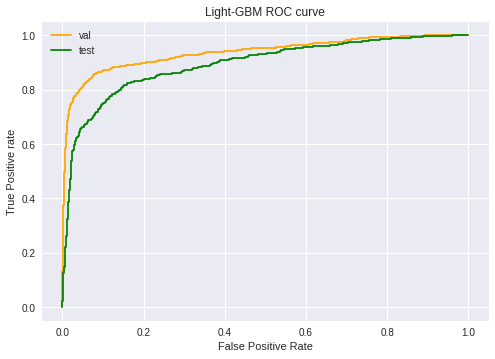

In [ ]:

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_val, tpr_val, linestyle='-',color='orange', label='val')
plt.plot(fpr_test, tpr_test, linestyle='-',color='green', label='test')
# plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Light-GBM ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();

#### SVM

In [ ]:
svm_clf = svm.SVC(probability=True, class_weight='balanced')
svm_clf.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [ ]:
final_val = svm_clf.predict_proba(X_val)
final_test = svm_clf.predict_proba(X_test)

fpr_val, tpr_val, thresh_val = roc_curve(y_val, final_val[:, 1], pos_label=1)
fpr_test, tpr_test, thresh_test = roc_curve(y_test, final_test[:, 1], pos_label=1)

auc_val = roc_auc_score(y_val, final_val[:, 1])
auc_test = roc_auc_score(y_test, final_test[:, 1])

print(auc_val, auc_test)

0.7986054361592486 0.7329531517423451


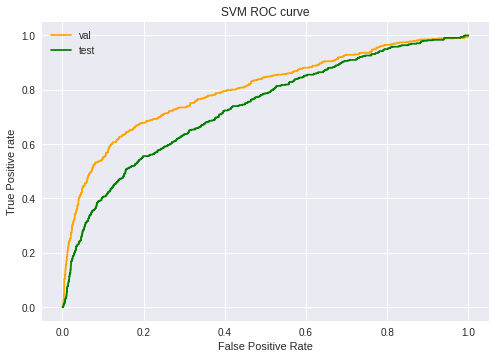

In [ ]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_val, tpr_val, linestyle='-',color='orange', label='val')
plt.plot(fpr_test, tpr_test, linestyle='-',color='green', label='test')
# plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('SVM ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();

### Coswara

#### LGBM

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [ ]:
NUM_BOOST_ROUND = 10000
# NUM_CLASS = 2

params = {'objective':'binary',
          'boosting_type': 'gbdt',
          'metric' : 'auc',
          'learning_rate':0.03,
          'subsample':0.68,
          'tree_learner': 'serial',
          'colsample_bytree':0.28,
          'early_stopping_rounds':300,
          'subsample_freq': 1,
          'reg_lambda': 2,
          'reg_alpha': 1,
          # 'num_leaves': 400,
          'random_state': 1999,
          'feature_fraction': 0.7,
          'min_data_in_leaf': 300,
          'bagging_fraction': 0.8,
          'bagging_freq': 10,
          'max_depth': 8
          }

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

seed_final_test = np.zeros(X_test.shape[0])
seed_final_val = np.zeros(X_val.shape[0])

seeds = range(30)

NUM_BOOST_ROUND = 1000
EARLY_STOPPING_ROUND = 100

SEED = 1999
n_splits = 3


# feature_important = None

for seed in seeds:
    final_test = np.zeros(X_test.shape[0])
    final_val = np.zeros(X_val.shape[0])

    logger.info(f'----------- seed: {seed} -----------')
    kfolds = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for trn_ind, val_ind in kfolds.split(X=X_train, y=y_train):

        kf_x_train, kf_y_train = X_train[trn_ind], y_train[trn_ind]
        kf_x_valid, kf_y_valid = X_train[val_ind], y_train[val_ind]
        
        print(kf_x_train.shape, kf_y_train.shape)
        
        dtrain = lgb.Dataset(kf_x_train, kf_y_train)
        dvalid = lgb.Dataset(kf_x_valid, kf_y_valid)
        
        params['random_state'] = seed

        model = lgb.train(params, 
                          dtrain, 
                          num_boost_round=NUM_BOOST_ROUND,
                          early_stopping_rounds=EARLY_STOPPING_ROUND,
                          valid_sets=(dtrain, dvalid), 
                          valid_names=('train','valid'),
                          verbose_eval = 100)

        test_pred  = model.predict(X_test)
        valid_pred = model.predict(X_val)

        # take the probability of second label
        final_test += test_pred
        final_val += valid_pred

        print('='*80)

    final_test /= n_splits
    final_val /= n_splits
    seed_final_test += final_test
    seed_final_val += final_val
    
seed_final_test /= len(seeds)
seed_final_val /= len(seeds)

2022-03-13 03:24:05,135 - ML MODEL - INFO - ----------- seed: 0 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.783402	valid's auc: 0.695204
[200]	train's auc: 0.822783	valid's auc: 0.709636
[300]	train's auc: 0.855799	valid's auc: 0.716453
[400]	train's auc: 0.881988	valid's auc: 0.723186
[500]	train's auc: 0.906937	valid's auc: 0.729446
[600]	train's auc: 0.922567	valid's auc: 0.733081
[700]	train's auc: 0.937524	valid's auc: 0.735214
[800]	train's auc: 0.948918	valid's auc: 0.738312
[900]	train's auc: 0.958271	valid's auc: 0.739435
[1000]	train's auc: 0.965608	valid's auc: 0.741803
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965608	valid's auc: 0.741803
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.777032	valid's auc: 0.695988
[200]	train's auc: 0.819692	valid's auc: 0.709711
[300]	train's auc: 0.85245	valid's auc: 0.717006
[400]	train's auc: 0.87984	valid's auc: 0.723157
[500]	train's auc: 0.902234	valid'

2022-03-13 03:24:28,863 - ML MODEL - INFO - ----------- seed: 1 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.78469	valid's auc: 0.698882
[200]	train's auc: 0.824264	valid's auc: 0.712341
[300]	train's auc: 0.857226	valid's auc: 0.721755
[400]	train's auc: 0.884175	valid's auc: 0.727256
[500]	train's auc: 0.904878	valid's auc: 0.732048
[600]	train's auc: 0.923238	valid's auc: 0.736149
[700]	train's auc: 0.93866	valid's auc: 0.739776
[800]	train's auc: 0.949625	valid's auc: 0.743222
[900]	train's auc: 0.958745	valid's auc: 0.744987
[1000]	train's auc: 0.965767	valid's auc: 0.74672
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965767	valid's auc: 0.74672
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.779227	valid's auc: 0.691981
[200]	train's auc: 0.820652	valid's auc: 0.706621
[300]	train's auc: 0.850944	valid's auc: 0.714061
[400]	train's auc: 0.876605	valid's auc: 0.720243
[500]	train's auc: 0.900234	valid's 

2022-03-13 03:24:49,928 - ML MODEL - INFO - ----------- seed: 2 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.779414	valid's auc: 0.695681
[200]	train's auc: 0.821548	valid's auc: 0.707823
[300]	train's auc: 0.851509	valid's auc: 0.715559
[400]	train's auc: 0.878612	valid's auc: 0.720792
[500]	train's auc: 0.902726	valid's auc: 0.726982
[600]	train's auc: 0.922384	valid's auc: 0.732602
[700]	train's auc: 0.937304	valid's auc: 0.736172
[800]	train's auc: 0.947785	valid's auc: 0.7396
[900]	train's auc: 0.958177	valid's auc: 0.740955
[1000]	train's auc: 0.965997	valid's auc: 0.74355
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965997	valid's auc: 0.74355
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.779004	valid's auc: 0.694877
[200]	train's auc: 0.819954	valid's auc: 0.710542
[300]	train's auc: 0.85118	valid's auc: 0.717456
[400]	train's auc: 0.878803	valid's auc: 0.724386
[500]	train's auc: 0.90176	valid's au

2022-03-13 03:25:10,857 - ML MODEL - INFO - ----------- seed: 3 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.785078	valid's auc: 0.700453
[200]	train's auc: 0.824513	valid's auc: 0.713961
[300]	train's auc: 0.857803	valid's auc: 0.719717
[400]	train's auc: 0.884455	valid's auc: 0.726136
[500]	train's auc: 0.907622	valid's auc: 0.730544
[600]	train's auc: 0.923467	valid's auc: 0.734232
[700]	train's auc: 0.93757	valid's auc: 0.737043
[800]	train's auc: 0.94924	valid's auc: 0.739733
[900]	train's auc: 0.958168	valid's auc: 0.740828
[1000]	train's auc: 0.965879	valid's auc: 0.742755
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965879	valid's auc: 0.742755
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.782152	valid's auc: 0.693039
[200]	train's auc: 0.81973	valid's auc: 0.70502
[300]	train's auc: 0.851615	valid's auc: 0.710859
[400]	train's auc: 0.878612	valid's auc: 0.718303
[500]	train's auc: 0.901293	valid's 

2022-03-13 03:25:31,955 - ML MODEL - INFO - ----------- seed: 4 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.783448	valid's auc: 0.697859
[200]	train's auc: 0.824041	valid's auc: 0.709511
[300]	train's auc: 0.857151	valid's auc: 0.718279
[400]	train's auc: 0.882756	valid's auc: 0.723495
[500]	train's auc: 0.904756	valid's auc: 0.725949
[600]	train's auc: 0.922091	valid's auc: 0.731274
[700]	train's auc: 0.937022	valid's auc: 0.735211
[800]	train's auc: 0.949723	valid's auc: 0.739034
[900]	train's auc: 0.958824	valid's auc: 0.740518
[1000]	train's auc: 0.966277	valid's auc: 0.742206
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.966277	valid's auc: 0.742206
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.776378	valid's auc: 0.692918
[200]	train's auc: 0.819698	valid's auc: 0.707342
[300]	train's auc: 0.852282	valid's auc: 0.715704
[400]	train's auc: 0.878073	valid's auc: 0.721131
[500]	train's auc: 0.900133	vali

2022-03-13 03:25:51,971 - ML MODEL - INFO - ----------- seed: 5 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.785044	valid's auc: 0.704015
[200]	train's auc: 0.819912	valid's auc: 0.711682
[300]	train's auc: 0.854796	valid's auc: 0.719289
[400]	train's auc: 0.883796	valid's auc: 0.727422
[500]	train's auc: 0.90574	valid's auc: 0.730938
[600]	train's auc: 0.921995	valid's auc: 0.73404
[700]	train's auc: 0.937663	valid's auc: 0.738453
[800]	train's auc: 0.948515	valid's auc: 0.741665
[900]	train's auc: 0.958437	valid's auc: 0.742699
[1000]	train's auc: 0.965891	valid's auc: 0.745141
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965891	valid's auc: 0.745141
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.782129	valid's auc: 0.697897
[200]	train's auc: 0.821734	valid's auc: 0.709684
[300]	train's auc: 0.853421	valid's auc: 0.715392
[400]	train's auc: 0.882242	valid's auc: 0.722523
[500]	train's auc: 0.901065	valid'

2022-03-13 03:26:13,543 - ML MODEL - INFO - ----------- seed: 6 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.78096	valid's auc: 0.695103
[200]	train's auc: 0.826198	valid's auc: 0.71168
[300]	train's auc: 0.85836	valid's auc: 0.719615
[400]	train's auc: 0.883742	valid's auc: 0.725895
[500]	train's auc: 0.904808	valid's auc: 0.731343
[600]	train's auc: 0.924623	valid's auc: 0.734176
[700]	train's auc: 0.937699	valid's auc: 0.737936
[800]	train's auc: 0.949078	valid's auc: 0.741085
[900]	train's auc: 0.958683	valid's auc: 0.743124
[1000]	train's auc: 0.966575	valid's auc: 0.745153
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.966575	valid's auc: 0.745153
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781333	valid's auc: 0.698599
[200]	train's auc: 0.821252	valid's auc: 0.711327
[300]	train's auc: 0.852882	valid's auc: 0.719429
[400]	train's auc: 0.879864	valid's auc: 0.725654
[500]	train's auc: 0.901201	valid's

2022-03-13 03:26:33,838 - ML MODEL - INFO - ----------- seed: 7 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.783874	valid's auc: 0.698597
[200]	train's auc: 0.819324	valid's auc: 0.715319
[300]	train's auc: 0.854701	valid's auc: 0.724512
[400]	train's auc: 0.883446	valid's auc: 0.72982
[500]	train's auc: 0.904899	valid's auc: 0.735362
[600]	train's auc: 0.922972	valid's auc: 0.738884
[700]	train's auc: 0.937031	valid's auc: 0.742054
[800]	train's auc: 0.950189	valid's auc: 0.745666
[900]	train's auc: 0.95807	valid's auc: 0.747744
[1000]	train's auc: 0.965651	valid's auc: 0.749486
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965651	valid's auc: 0.749486
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.777124	valid's auc: 0.697399
[200]	train's auc: 0.817603	valid's auc: 0.70728
[300]	train's auc: 0.849511	valid's auc: 0.715443
[400]	train's auc: 0.878896	valid's auc: 0.722766
[500]	train's auc: 0.901765	valid's

2022-03-13 03:26:53,928 - ML MODEL - INFO - ----------- seed: 8 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.782372	valid's auc: 0.699223
[200]	train's auc: 0.821043	valid's auc: 0.713882
[300]	train's auc: 0.856921	valid's auc: 0.719514
[400]	train's auc: 0.883038	valid's auc: 0.724148
[500]	train's auc: 0.904686	valid's auc: 0.730151
[600]	train's auc: 0.923205	valid's auc: 0.733292
[700]	train's auc: 0.936916	valid's auc: 0.735331
[800]	train's auc: 0.947677	valid's auc: 0.739262
[900]	train's auc: 0.95794	valid's auc: 0.742761
[1000]	train's auc: 0.965662	valid's auc: 0.74432
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965662	valid's auc: 0.74432
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.780881	valid's auc: 0.695282
[200]	train's auc: 0.822126	valid's auc: 0.706539
[300]	train's auc: 0.853144	valid's auc: 0.714039
[400]	train's auc: 0.879267	valid's auc: 0.719043
[500]	train's auc: 0.901139	valid's

2022-03-13 03:27:14,282 - ML MODEL - INFO - ----------- seed: 9 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781109	valid's auc: 0.700004
[200]	train's auc: 0.822333	valid's auc: 0.711643
[300]	train's auc: 0.854271	valid's auc: 0.721202
[400]	train's auc: 0.881693	valid's auc: 0.72689
[500]	train's auc: 0.904673	valid's auc: 0.732752
[600]	train's auc: 0.924724	valid's auc: 0.736998
[700]	train's auc: 0.937902	valid's auc: 0.740163
[800]	train's auc: 0.948274	valid's auc: 0.741528
[900]	train's auc: 0.958256	valid's auc: 0.742215
[1000]	train's auc: 0.965834	valid's auc: 0.745474
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965834	valid's auc: 0.745474
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.780225	valid's auc: 0.695948
[200]	train's auc: 0.817767	valid's auc: 0.708552
[300]	train's auc: 0.850385	valid's auc: 0.716954
[400]	train's auc: 0.878024	valid's auc: 0.722895
[500]	train's auc: 0.901638	valid

2022-03-13 03:27:34,533 - ML MODEL - INFO - ----------- seed: 10 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.782617	valid's auc: 0.696321
[200]	train's auc: 0.819113	valid's auc: 0.711781
[300]	train's auc: 0.853495	valid's auc: 0.719288
[400]	train's auc: 0.880277	valid's auc: 0.725504
[500]	train's auc: 0.903264	valid's auc: 0.731387
[600]	train's auc: 0.922828	valid's auc: 0.735309
[700]	train's auc: 0.938005	valid's auc: 0.739293
[800]	train's auc: 0.947442	valid's auc: 0.741626
[900]	train's auc: 0.957619	valid's auc: 0.744819
[1000]	train's auc: 0.965414	valid's auc: 0.746864
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965414	valid's auc: 0.746864
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.777413	valid's auc: 0.693406
[200]	train's auc: 0.819858	valid's auc: 0.707221
[300]	train's auc: 0.850625	valid's auc: 0.715426
[400]	train's auc: 0.876985	valid's auc: 0.72225
[500]	train's auc: 0.899267	valid

2022-03-13 03:27:55,192 - ML MODEL - INFO - ----------- seed: 11 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781865	valid's auc: 0.699327
[200]	train's auc: 0.822927	valid's auc: 0.71098
[300]	train's auc: 0.854073	valid's auc: 0.720411
[400]	train's auc: 0.88501	valid's auc: 0.725507
[500]	train's auc: 0.906851	valid's auc: 0.729763
[600]	train's auc: 0.923021	valid's auc: 0.732266
[700]	train's auc: 0.937391	valid's auc: 0.735574
[800]	train's auc: 0.949164	valid's auc: 0.738788
[900]	train's auc: 0.958236	valid's auc: 0.74122
[1000]	train's auc: 0.966606	valid's auc: 0.74352
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.966606	valid's auc: 0.74352
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.779646	valid's auc: 0.695421
[200]	train's auc: 0.820523	valid's auc: 0.708245
[300]	train's auc: 0.851418	valid's auc: 0.716166
[400]	train's auc: 0.877961	valid's auc: 0.723178
[500]	train's auc: 0.900302	valid's a

2022-03-13 03:28:15,544 - ML MODEL - INFO - ----------- seed: 12 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.78314	valid's auc: 0.697961
[200]	train's auc: 0.822225	valid's auc: 0.713578
[300]	train's auc: 0.856662	valid's auc: 0.721936
[400]	train's auc: 0.883817	valid's auc: 0.727402
[500]	train's auc: 0.904806	valid's auc: 0.730676
[600]	train's auc: 0.92402	valid's auc: 0.735173
[700]	train's auc: 0.937978	valid's auc: 0.738387
[800]	train's auc: 0.948045	valid's auc: 0.741146
[900]	train's auc: 0.957992	valid's auc: 0.742916
[1000]	train's auc: 0.965511	valid's auc: 0.745536
Did not meet early stopping. Best iteration is:
[999]	train's auc: 0.965542	valid's auc: 0.745509
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.774485	valid's auc: 0.691737
[200]	train's auc: 0.820554	valid's auc: 0.709163
[300]	train's auc: 0.854463	valid's auc: 0.717765
[400]	train's auc: 0.88125	valid's auc: 0.724758
[500]	train's auc: 0.903591	valid's 

2022-03-13 03:28:35,673 - ML MODEL - INFO - ----------- seed: 13 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.783042	valid's auc: 0.695893
[200]	train's auc: 0.824771	valid's auc: 0.709358
[300]	train's auc: 0.855659	valid's auc: 0.718853
[400]	train's auc: 0.883971	valid's auc: 0.72358
[500]	train's auc: 0.904542	valid's auc: 0.727493
[600]	train's auc: 0.922197	valid's auc: 0.732067
[700]	train's auc: 0.937057	valid's auc: 0.734718
[800]	train's auc: 0.948943	valid's auc: 0.737311
[900]	train's auc: 0.957562	valid's auc: 0.739382
[1000]	train's auc: 0.965239	valid's auc: 0.741285
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965239	valid's auc: 0.741285
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.776785	valid's auc: 0.694831
[200]	train's auc: 0.818801	valid's auc: 0.708128
[300]	train's auc: 0.853039	valid's auc: 0.717642
[400]	train's auc: 0.879919	valid's auc: 0.723527
[500]	train's auc: 0.901393	valid

2022-03-13 03:28:55,995 - ML MODEL - INFO - ----------- seed: 14 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781345	valid's auc: 0.700059
[200]	train's auc: 0.818457	valid's auc: 0.711927
[300]	train's auc: 0.854027	valid's auc: 0.71976
[400]	train's auc: 0.885419	valid's auc: 0.725969
[500]	train's auc: 0.906694	valid's auc: 0.732214
[600]	train's auc: 0.923724	valid's auc: 0.736547
[700]	train's auc: 0.938801	valid's auc: 0.741349
[800]	train's auc: 0.949601	valid's auc: 0.745212
[900]	train's auc: 0.958735	valid's auc: 0.748297
[1000]	train's auc: 0.966762	valid's auc: 0.750792
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.966762	valid's auc: 0.750792
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.783226	valid's auc: 0.697017
[200]	train's auc: 0.822256	valid's auc: 0.709383
[300]	train's auc: 0.852487	valid's auc: 0.717371
[400]	train's auc: 0.878245	valid's auc: 0.723955
[500]	train's auc: 0.901681	valid

2022-03-13 03:29:16,253 - ML MODEL - INFO - ----------- seed: 15 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.78325	valid's auc: 0.69891
[200]	train's auc: 0.823646	valid's auc: 0.71253
[300]	train's auc: 0.857805	valid's auc: 0.720341
[400]	train's auc: 0.885446	valid's auc: 0.725525
[500]	train's auc: 0.906818	valid's auc: 0.729142
[600]	train's auc: 0.924772	valid's auc: 0.733638
[700]	train's auc: 0.938172	valid's auc: 0.735888
[800]	train's auc: 0.948449	valid's auc: 0.738103
[900]	train's auc: 0.958292	valid's auc: 0.741045
[1000]	train's auc: 0.966107	valid's auc: 0.743109
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.966107	valid's auc: 0.743109
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781668	valid's auc: 0.695209
[200]	train's auc: 0.82312	valid's auc: 0.70974
[300]	train's auc: 0.854374	valid's auc: 0.715796
[400]	train's auc: 0.881473	valid's auc: 0.721709
[500]	train's auc: 0.903802	valid's a

2022-03-13 03:29:47,047 - ML MODEL - INFO - ----------- seed: 16 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.780563	valid's auc: 0.701408
[200]	train's auc: 0.820955	valid's auc: 0.711919
[300]	train's auc: 0.854263	valid's auc: 0.719187
[400]	train's auc: 0.880639	valid's auc: 0.724262
[500]	train's auc: 0.905174	valid's auc: 0.729498
[600]	train's auc: 0.923302	valid's auc: 0.734263
[700]	train's auc: 0.93716	valid's auc: 0.737811
[800]	train's auc: 0.94942	valid's auc: 0.740956
[900]	train's auc: 0.958771	valid's auc: 0.74436
[1000]	train's auc: 0.967274	valid's auc: 0.74729
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.967274	valid's auc: 0.74729
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.780164	valid's auc: 0.698225
[200]	train's auc: 0.822157	valid's auc: 0.711881
[300]	train's auc: 0.852937	valid's auc: 0.717974
[400]	train's auc: 0.878603	valid's auc: 0.722248
[500]	train's auc: 0.900473	valid's a

2022-03-13 03:30:07,812 - ML MODEL - INFO - ----------- seed: 17 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781891	valid's auc: 0.696214
[200]	train's auc: 0.82029	valid's auc: 0.710416
[300]	train's auc: 0.854809	valid's auc: 0.719244
[400]	train's auc: 0.87984	valid's auc: 0.724122
[500]	train's auc: 0.90286	valid's auc: 0.729073
[600]	train's auc: 0.920962	valid's auc: 0.733984
[700]	train's auc: 0.936668	valid's auc: 0.737848
[800]	train's auc: 0.948113	valid's auc: 0.740752
[900]	train's auc: 0.957398	valid's auc: 0.742772
[1000]	train's auc: 0.964839	valid's auc: 0.746137
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.964839	valid's auc: 0.746137
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781269	valid's auc: 0.693352
[200]	train's auc: 0.819887	valid's auc: 0.706908
[300]	train's auc: 0.850045	valid's auc: 0.716337
[400]	train's auc: 0.875855	valid's auc: 0.722869
[500]	train's auc: 0.899059	valid's

2022-03-13 03:30:28,915 - ML MODEL - INFO - ----------- seed: 18 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.783254	valid's auc: 0.699779
[200]	train's auc: 0.825269	valid's auc: 0.711326
[300]	train's auc: 0.856709	valid's auc: 0.720861
[400]	train's auc: 0.886216	valid's auc: 0.727746
[500]	train's auc: 0.908236	valid's auc: 0.730043
[600]	train's auc: 0.925189	valid's auc: 0.734928
[700]	train's auc: 0.938501	valid's auc: 0.737306
[800]	train's auc: 0.950062	valid's auc: 0.740886
[900]	train's auc: 0.959839	valid's auc: 0.744045
[1000]	train's auc: 0.967954	valid's auc: 0.746116
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.967954	valid's auc: 0.746116
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.779283	valid's auc: 0.693705
[200]	train's auc: 0.821168	valid's auc: 0.708376
[300]	train's auc: 0.854009	valid's auc: 0.718014
[400]	train's auc: 0.880008	valid's auc: 0.726182
[500]	train's auc: 0.90286	valid

2022-03-13 03:30:49,526 - ML MODEL - INFO - ----------- seed: 19 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.783941	valid's auc: 0.698785
[200]	train's auc: 0.821328	valid's auc: 0.710624
[300]	train's auc: 0.854496	valid's auc: 0.71795
[400]	train's auc: 0.883499	valid's auc: 0.723197
[500]	train's auc: 0.903769	valid's auc: 0.727593
[600]	train's auc: 0.922393	valid's auc: 0.730615
[700]	train's auc: 0.93642	valid's auc: 0.73404
[800]	train's auc: 0.947759	valid's auc: 0.738192
[900]	train's auc: 0.957407	valid's auc: 0.741627
[1000]	train's auc: 0.965543	valid's auc: 0.744548
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965543	valid's auc: 0.744548
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781739	valid's auc: 0.696251
[200]	train's auc: 0.821922	valid's auc: 0.709392
[300]	train's auc: 0.852649	valid's auc: 0.717237
[400]	train's auc: 0.878844	valid's auc: 0.725131
[500]	train's auc: 0.900907	valid's

2022-03-13 03:31:09,812 - ML MODEL - INFO - ----------- seed: 20 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.784029	valid's auc: 0.694049
[200]	train's auc: 0.824849	valid's auc: 0.710165
[300]	train's auc: 0.855806	valid's auc: 0.717872
[400]	train's auc: 0.884522	valid's auc: 0.725204
[500]	train's auc: 0.907273	valid's auc: 0.72964
[600]	train's auc: 0.925515	valid's auc: 0.732444
[700]	train's auc: 0.939038	valid's auc: 0.736664
[800]	train's auc: 0.9509	valid's auc: 0.739152
[900]	train's auc: 0.960415	valid's auc: 0.742997
[1000]	train's auc: 0.967989	valid's auc: 0.745741
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.967989	valid's auc: 0.745741
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.780858	valid's auc: 0.693706
[200]	train's auc: 0.817864	valid's auc: 0.704316
[300]	train's auc: 0.851994	valid's auc: 0.714071
[400]	train's auc: 0.878468	valid's auc: 0.720225
[500]	train's auc: 0.900568	valid's

2022-03-13 03:31:29,547 - ML MODEL - INFO - ----------- seed: 21 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.779397	valid's auc: 0.694758
[200]	train's auc: 0.820283	valid's auc: 0.712128
[300]	train's auc: 0.851638	valid's auc: 0.719225
[400]	train's auc: 0.880815	valid's auc: 0.724716
[500]	train's auc: 0.904251	valid's auc: 0.728811
[600]	train's auc: 0.923071	valid's auc: 0.733553
[700]	train's auc: 0.937405	valid's auc: 0.73739
[800]	train's auc: 0.949172	valid's auc: 0.739595
[900]	train's auc: 0.959255	valid's auc: 0.742718
[1000]	train's auc: 0.965964	valid's auc: 0.744805
Did not meet early stopping. Best iteration is:
[998]	train's auc: 0.965981	valid's auc: 0.744643
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.783467	valid's auc: 0.695806
[200]	train's auc: 0.823959	valid's auc: 0.708444
[300]	train's auc: 0.854044	valid's auc: 0.717779
[400]	train's auc: 0.88022	valid's auc: 0.723831
[500]	train's auc: 0.902389	valid's

2022-03-13 03:31:49,309 - ML MODEL - INFO - ----------- seed: 22 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781052	valid's auc: 0.697975
[200]	train's auc: 0.823711	valid's auc: 0.714244
[300]	train's auc: 0.851861	valid's auc: 0.721363
[400]	train's auc: 0.883539	valid's auc: 0.727923
[500]	train's auc: 0.904335	valid's auc: 0.730344
[600]	train's auc: 0.922117	valid's auc: 0.733495
[700]	train's auc: 0.937503	valid's auc: 0.738152
[800]	train's auc: 0.948932	valid's auc: 0.740943
[900]	train's auc: 0.957261	valid's auc: 0.743065
[1000]	train's auc: 0.964916	valid's auc: 0.745821
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.964916	valid's auc: 0.745821
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.779824	valid's auc: 0.696408
[200]	train's auc: 0.819251	valid's auc: 0.708519
[300]	train's auc: 0.852589	valid's auc: 0.717517
[400]	train's auc: 0.880728	valid's auc: 0.724562
[500]	train's auc: 0.902325	vali

2022-03-13 03:32:09,165 - ML MODEL - INFO - ----------- seed: 23 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.78157	valid's auc: 0.699194
[200]	train's auc: 0.82432	valid's auc: 0.713467
[300]	train's auc: 0.858044	valid's auc: 0.722917
[400]	train's auc: 0.886416	valid's auc: 0.730353
[500]	train's auc: 0.905566	valid's auc: 0.734548
[600]	train's auc: 0.923584	valid's auc: 0.737194
[700]	train's auc: 0.937617	valid's auc: 0.738922
[800]	train's auc: 0.948603	valid's auc: 0.742598
[900]	train's auc: 0.958352	valid's auc: 0.744851
[1000]	train's auc: 0.966903	valid's auc: 0.747363
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.966903	valid's auc: 0.747363
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.779318	valid's auc: 0.697917
[200]	train's auc: 0.819896	valid's auc: 0.709955
[300]	train's auc: 0.850266	valid's auc: 0.717059
[400]	train's auc: 0.877689	valid's auc: 0.72344
[500]	train's auc: 0.900144	valid's

2022-03-13 03:32:29,296 - ML MODEL - INFO - ----------- seed: 24 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781722	valid's auc: 0.7025
[200]	train's auc: 0.820952	valid's auc: 0.716258
[300]	train's auc: 0.855064	valid's auc: 0.722844
[400]	train's auc: 0.884892	valid's auc: 0.729951
[500]	train's auc: 0.904834	valid's auc: 0.734831
[600]	train's auc: 0.924113	valid's auc: 0.738157
[700]	train's auc: 0.939433	valid's auc: 0.741077
[800]	train's auc: 0.950781	valid's auc: 0.743229
[900]	train's auc: 0.960175	valid's auc: 0.744881
[1000]	train's auc: 0.968106	valid's auc: 0.746451
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.968106	valid's auc: 0.746451
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.782092	valid's auc: 0.696026
[200]	train's auc: 0.824986	valid's auc: 0.709827
[300]	train's auc: 0.855414	valid's auc: 0.719198
[400]	train's auc: 0.881774	valid's auc: 0.727055
[500]	train's auc: 0.903253	valid'

2022-03-13 03:32:49,152 - ML MODEL - INFO - ----------- seed: 25 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.782112	valid's auc: 0.700002
[200]	train's auc: 0.822389	valid's auc: 0.713312
[300]	train's auc: 0.855546	valid's auc: 0.721855
[400]	train's auc: 0.882901	valid's auc: 0.727236
[500]	train's auc: 0.906247	valid's auc: 0.731501
[600]	train's auc: 0.923033	valid's auc: 0.73474
[700]	train's auc: 0.937626	valid's auc: 0.737971
[800]	train's auc: 0.948554	valid's auc: 0.741824
[900]	train's auc: 0.957127	valid's auc: 0.742957
[1000]	train's auc: 0.965119	valid's auc: 0.745156
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.965119	valid's auc: 0.745156
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.778574	valid's auc: 0.693112
[200]	train's auc: 0.819306	valid's auc: 0.705595
[300]	train's auc: 0.848111	valid's auc: 0.712761
[400]	train's auc: 0.876203	valid's auc: 0.719494
[500]	train's auc: 0.898276	valid

2022-03-13 03:33:09,261 - ML MODEL - INFO - ----------- seed: 26 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.78056	valid's auc: 0.697913
[200]	train's auc: 0.82235	valid's auc: 0.714559
[300]	train's auc: 0.854829	valid's auc: 0.721075
[400]	train's auc: 0.884424	valid's auc: 0.72588
[500]	train's auc: 0.90734	valid's auc: 0.731821
[600]	train's auc: 0.923949	valid's auc: 0.734805
[700]	train's auc: 0.938143	valid's auc: 0.73772
[800]	train's auc: 0.949729	valid's auc: 0.740922
[900]	train's auc: 0.959015	valid's auc: 0.743903
[1000]	train's auc: 0.966597	valid's auc: 0.745689
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.966597	valid's auc: 0.745689
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781621	valid's auc: 0.695442
[200]	train's auc: 0.822259	valid's auc: 0.705018
[300]	train's auc: 0.853883	valid's auc: 0.713044
[400]	train's auc: 0.878614	valid's auc: 0.718144
[500]	train's auc: 0.897559	valid's a

2022-03-13 03:33:29,430 - ML MODEL - INFO - ----------- seed: 27 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781334	valid's auc: 0.695277
[200]	train's auc: 0.820568	valid's auc: 0.709426
[300]	train's auc: 0.852206	valid's auc: 0.716713
[400]	train's auc: 0.881686	valid's auc: 0.724014
[500]	train's auc: 0.904595	valid's auc: 0.729769
[600]	train's auc: 0.923575	valid's auc: 0.732977
[700]	train's auc: 0.937705	valid's auc: 0.736061
[800]	train's auc: 0.949351	valid's auc: 0.738389
[900]	train's auc: 0.959149	valid's auc: 0.740415
[1000]	train's auc: 0.966731	valid's auc: 0.742403
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.966731	valid's auc: 0.742403
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.778243	valid's auc: 0.693654
[200]	train's auc: 0.822571	valid's auc: 0.70792
[300]	train's auc: 0.854514	valid's auc: 0.716934
[400]	train's auc: 0.880836	valid's auc: 0.723493
[500]	train's auc: 0.901397	valid

2022-03-13 03:33:49,532 - ML MODEL - INFO - ----------- seed: 28 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.781349	valid's auc: 0.698841
[200]	train's auc: 0.823722	valid's auc: 0.714033
[300]	train's auc: 0.85725	valid's auc: 0.721218
[400]	train's auc: 0.884154	valid's auc: 0.726607
[500]	train's auc: 0.906562	valid's auc: 0.731937
[600]	train's auc: 0.923238	valid's auc: 0.735876
[700]	train's auc: 0.936729	valid's auc: 0.739273
[800]	train's auc: 0.948823	valid's auc: 0.740469
[900]	train's auc: 0.957753	valid's auc: 0.742314
[1000]	train's auc: 0.966423	valid's auc: 0.745037
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.966423	valid's auc: 0.745037
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.77927	valid's auc: 0.693179
[200]	train's auc: 0.822183	valid's auc: 0.70765
[300]	train's auc: 0.852468	valid's auc: 0.716974
[400]	train's auc: 0.878362	valid's auc: 0.723812
[500]	train's auc: 0.898205	valid's

2022-03-13 03:34:09,939 - ML MODEL - INFO - ----------- seed: 29 -----------


(12204, 26) (12204,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.780986	valid's auc: 0.697514
[200]	train's auc: 0.821384	valid's auc: 0.711336
[300]	train's auc: 0.855362	valid's auc: 0.718756
[400]	train's auc: 0.882104	valid's auc: 0.725704
[500]	train's auc: 0.904886	valid's auc: 0.731199
[600]	train's auc: 0.925373	valid's auc: 0.736257
[700]	train's auc: 0.939543	valid's auc: 0.740814
[800]	train's auc: 0.950489	valid's auc: 0.744471
[900]	train's auc: 0.959346	valid's auc: 0.745689
[1000]	train's auc: 0.966517	valid's auc: 0.747577
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.966517	valid's auc: 0.747577
(12205, 26) (12205,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.783825	valid's auc: 0.696037
[200]	train's auc: 0.822877	valid's auc: 0.708391
[300]	train's auc: 0.853117	valid's auc: 0.717664
[400]	train's auc: 0.879447	valid's auc: 0.723745
[500]	train's auc: 0.902243	vali

In [ ]:
print(seed_final_test)
print(seed_final_val)

[0.23250691 0.05233176 0.19109774 ... 0.50046167 0.12546846 0.12972881]
[0.21586403 0.14209096 0.18414562 ... 0.15840545 0.40915642 0.2003341 ]


In [ ]:
fpr_val, tpr_val, thresh_val = roc_curve(y_val, seed_final_val, pos_label=1)
fpr_test, tpr_test, thresh_test = roc_curve(y_test, seed_final_test, pos_label=1)

auc_val = roc_auc_score(y_val, seed_final_val)
auc_test = roc_auc_score(y_test, seed_final_test)

In [ ]:
logger.info(f'auc val: {auc_val}')
logger.info(f'auc test: {auc_test}')

2022-03-13 03:34:45,747 - ML MODEL - INFO - auc val: 0.5969949194681656
2022-03-13 03:34:45,749 - ML MODEL - INFO - auc test: 0.6597464617091789


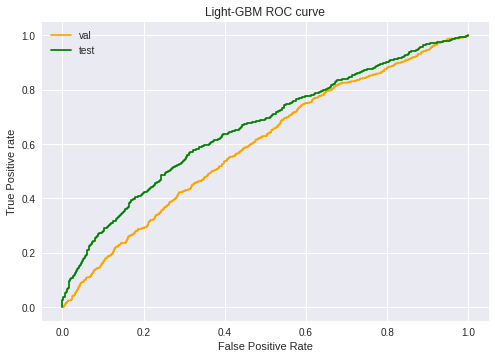

In [ ]:

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_val, tpr_val, linestyle='-',color='orange', label='val')
plt.plot(fpr_test, tpr_test, linestyle='-',color='green', label='test')
# plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Light-GBM ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();

### Coughvid

#### LGBM

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [ ]:
NUM_BOOST_ROUND = 10000
# NUM_CLASS = 2

params = {'objective':'binary',
          'boosting_type': 'gbdt',
          'metric' : 'auc',
          'learning_rate':0.01,
          'subsample':0.68,
          'tree_learner': 'serial',
          'colsample_bytree':0.28,
          'early_stopping_rounds':300,
          'subsample_freq': 1,
          'reg_lambda': 2,
          'reg_alpha': 1,
          'num_leaves': 400,
          'random_state': 1999,
          'feature_fraction': 0.7,
          'min_data_in_leaf': 300,
          'bagging_fraction': 0.8,
          'bagging_freq': 10,
          'max_depth': 8
          }

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

seed_final_test = np.zeros(X_test.shape[0])
seed_final_val = np.zeros(X_val.shape[0])

seeds = range(30)

NUM_BOOST_ROUND = 1000
EARLY_STOPPING_ROUND = 100

SEED = 1999
n_splits = 3


# feature_important = None

for seed in seeds:
    final_test = np.zeros(X_test.shape[0])
    final_val = np.zeros(X_val.shape[0])

    logger.info(f'----------- seed: {seed} -----------')
    kfolds = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for trn_ind, val_ind in kfolds.split(X=X_train, y=y_train):

        kf_x_train, kf_y_train = X_train[trn_ind], y_train[trn_ind]
        kf_x_valid, kf_y_valid = X_train[val_ind], y_train[val_ind]
        
        print(kf_x_train.shape, kf_y_train.shape)
        
        dtrain = lgb.Dataset(kf_x_train, kf_y_train)
        dvalid = lgb.Dataset(kf_x_valid, kf_y_valid)
        
        params['random_state'] = seed

        model = lgb.train(params, 
                          dtrain, 
                          num_boost_round=NUM_BOOST_ROUND,
                          early_stopping_rounds=EARLY_STOPPING_ROUND,
                          valid_sets=(dtrain, dvalid), 
                          valid_names=('train','valid'),
                          verbose_eval = 100)

        test_pred  = model.predict(X_test)
        valid_pred = model.predict(X_val)

        # take the probability of second label
        final_test += test_pred
        final_val += valid_pred

        print('='*80)

    final_test /= n_splits
    final_val /= n_splits
    seed_final_test += final_test
    seed_final_val += final_val
    
seed_final_test /= len(seeds)
seed_final_val /= len(seeds)

2022-03-13 02:45:39,658 - ML MODEL - INFO - ----------- seed: 0 -----------


(28273, 224) (28273,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.691584	valid's auc: 0.567913
[200]	train's auc: 0.717408	valid's auc: 0.568462
[300]	train's auc: 0.734357	valid's auc: 0.570847
[400]	train's auc: 0.749316	valid's auc: 0.570322
[500]	train's auc: 0.763813	valid's auc: 0.5722
[600]	train's auc: 0.776945	valid's auc: 0.573009
[700]	train's auc: 0.788188	valid's auc: 0.573533
[800]	train's auc: 0.799847	valid's auc: 0.574827
[900]	train's auc: 0.809613	valid's auc: 0.575713
[1000]	train's auc: 0.819279	valid's auc: 0.576554
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.819279	valid's auc: 0.576554
(28273, 224) (28273,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.688432	valid's auc: 0.560392
[200]	train's auc: 0.713029	valid's auc: 0.562805
[300]	train's auc: 0.732678	valid's auc: 0.565275
[400]	train's auc: 0.747185	valid's auc: 0.566095
[500]	train's auc: 0.761328	vali

2022-03-13 02:47:23,221 - ML MODEL - INFO - ----------- seed: 1 -----------


(28273, 224) (28273,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.686426	valid's auc: 0.565616
[200]	train's auc: 0.712173	valid's auc: 0.566767
[300]	train's auc: 0.732987	valid's auc: 0.569694
[400]	train's auc: 0.753071	valid's auc: 0.571108
[500]	train's auc: 0.766929	valid's auc: 0.572406
[600]	train's auc: 0.780523	valid's auc: 0.573022
[700]	train's auc: 0.789536	valid's auc: 0.573681
[800]	train's auc: 0.801987	valid's auc: 0.57452
[900]	train's auc: 0.811991	valid's auc: 0.573847
[1000]	train's auc: 0.820261	valid's auc: 0.574927
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.820261	valid's auc: 0.574927
(28273, 224) (28273,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.690375	valid's auc: 0.561477
[200]	train's auc: 0.714141	valid's auc: 0.56547
[300]	train's auc: 0.732564	valid's auc: 0.566989
[400]	train's auc: 0.746274	valid's auc: 0.568148
[500]	train's auc: 0.760598	vali

2022-03-13 02:49:11,744 - ML MODEL - INFO - ----------- seed: 2 -----------


(28273, 224) (28273,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.693641	valid's auc: 0.564708
[200]	train's auc: 0.715539	valid's auc: 0.567963
[300]	train's auc: 0.733747	valid's auc: 0.569189
[400]	train's auc: 0.749907	valid's auc: 0.571515


KeyboardInterrupt: ignored

In [ ]:
print(seed_final_test)
print(seed_final_val)

In [ ]:
fpr_val, tpr_val, thresh_val = roc_curve(y_val, seed_final_val, pos_label=1)
fpr_test, tpr_test, thresh_test = roc_curve(y_test, seed_final_test, pos_label=1)

auc_val = roc_auc_score(y_val, seed_final_val)
auc_test = roc_auc_score(y_test, seed_final_test)

In [ ]:
logger.info(f'auc val: {auc_val}')
logger.info(f'auc test: {auc_test}')

In [ ]:

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_val, tpr_val, linestyle='-',color='orange', label='val')
plt.plot(fpr_test, tpr_test, linestyle='-',color='green', label='test')
# plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Light-GBM ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();